In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import random

# Set the random seed for reproducibility
np.random.seed(42)

#Set Visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 7]


#### 1. Generate synthetic telecom network kpi data

In [56]:
def generate_telecom_kpi_data(days=14, samples_per_day=96):
    """
       Generate synthetic telecom network KPI data.
    
        Parameters:
        - days: Number of days to generate data for
        - samples_per_day: Number of samples per day (96 = every 15 minutes)
        
        Returns:
        - DataFrame with timestamp and KPI columns
    """
    total_samples = days * samples_per_day
    start_date = datetime(2024, 2, 1)
    timestamps = [start_date + timedelta(minutes=15*i) for i in range(total_samples) ]
    
    # Base Data patterns
    time_indices = np.arange(total_samples)
    
    # Traffic load( follows daily pattern with weekly pattern overlay)
    hour_of_day = np.array([t.hour + t.minute/60 for t in timestamps])
    day_of_week = np.array([t.weekday() for t in timestamps])
    
    # Daily traffic pattern (busier during the day, peak in the evening and less at night )
    daily_pattern = np.sin(hour_of_day * 2 * np.pi/24 - np.pi/2) * 0.5 + 0.5
    # Weekend effect
    weekend_effect = np.array([0.7 if d>=5 else 1.0 for d in day_of_week])
    
    # Traffic load with pattern and random noise
    traffic_load = (
        daily_pattern * weekend_effect * 100 + np.random.normal(0, 5, total_samples)
    )
    
    # Latency ( baseline + traffic-dependent component + random noise)
    latency_base = 20 # milliseconds
    latency = (
        latency_base + 0.1 * traffic_load + np.random.normal(0, 3, total_samples)
    )
    
    # Packet loss ( low baseline, increase with traffic load)
    packet_loss_base = 0.01 # 1%
    packet_loss = (
        packet_loss_base +
        0.0003 * traffic_load +
        np.random.exponential(0.05, total_samples)
    )
    
    # Connection success rate ( high baseline, decrease with traffic load)
    conn_success_base = 99.5 # 99.5%
    conn_success = (
        conn_success_base -
        0.01 * traffic_load -
        np.random.exponential(0.1, total_samples)
    )
    conn_success = np.clip(conn_success, 90, 100)
    
    # Signal strength ( mostly stable with some random fluctuations )
    signal_strength_base = -70 # dBm decible milliwatts
    signal_strength = (
        signal_strength_base + 
        np.random.normal(0, 2, total_samples)
    )
    
    # Introduce Anomalies
    
    #1. Network congestion event
    congestion_start = random.randint(samples_per_day*2, samples_per_day*10)
    congestion_duration = random.randint(4, 12) # 1 to 3 hours
    
    for i in range(congestion_start, congestion_start + congestion_duration):
        traffic_load[i] *= 1.5
        latency[i] *= 3
        packet_loss[i] *= 5
        conn_success[i] = max(conn_success[i] - 5, 90)
        signal_strength[i] -= 10
    
    #2. Network outage event (partial)
    outage_start = random.randint(samples_per_day*4, samples_per_day*12)
    outage_duration = random.randint(2, 6) # 30 minutes to 1.5 hours
    
    for i in range(outage_start, outage_start + outage_duration):
        traffic_load[i] *= 0.3
        latency[i] *= 3
        packet_loss[i] *= 10
        conn_success[i] = max(conn_success[i] - 15, 80)
        signal_strength[i] -= 10
    
    #3. Signal Interference event
    interference_start = random.randint(samples_per_day*6, samples_per_day*13)
    interference_duration = random.randint(8, 24) # 2 to 6 hours
    
    for i in range(interference_start, interference_start + interference_duration):
        signal_strength[i] -= 15
        conn_success[i] = max(conn_success[i] - 3, 90)
        packet_loss[i] *= 2
    
    # Create DataFrame
    df = pd.DataFrame({
        "timestamp": timestamps,
        "traffic_load_mbps": traffic_load,
        "latency_ms": latency,
        "packet_loss_pct": packet_loss,
        "conn_success_rate": conn_success,
        "signal_strength_dbm": signal_strength
    })
    
    # Add Derived Features
    df["hour_of_day"] = df["timestamp"].dt.hour
    df["day_of_week"] = df["timestamp"].dt.dayofweek
    df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x>=5 else 0)
    df["date"] = df["timestamp"].dt.date
    
    return df


### Generate synthetic KPI data


In [63]:
print("Synthetic Telecom Network KPI Data:")
telecom_kpi_data = generate_telecom_kpi_data(14)
display(telecom_kpi_data.head())

Synthetic Telecom Network KPI Data:


,timestamp,traffic_load_mbps,latency_ms,packet_loss_pct,conn_success_rate,signal_strength_dbm,hour_of_day,day_of_week,is_weekend,date
0,2024-02-01 00:00:00,6.844620,18.288145,0.015703,99.371145,-70.801784,0,3,0,2024-02-01
1,2024-02-01 00:15:00,-6.069779,18.522259,0.070540,99.352849,-72.696403,0,3,0,2024-02-01
2,2024-02-01 00:30:00,-0.624396,19.894252,0.017979,99.479558,-71.965990,0,3,0,2024-02-01
3,2024-02-01 00:45:00,-1.205290,16.624707,0.140520,99.390118,-69.174037,0,3,0,2024-02-01
4,2024-02-01 01:00:00,3.278252,23.281352,0.038026,99.439543,-69.935863,1,3,0,2024-02-01


### Basic Data exploration

In [ ]:
# Data shape and information

print(f"Data Shape: {telecom_kpi_data.shape}")
print("\nData Information:")
display(telecom_kpi_data.info())

Data Shape: (1344, 10)

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            1344 non-null   datetime64[ns]
 1   traffic_load_mbps    1344 non-null   float64       
 2   latency_ms           1344 non-null   float64       
 3   packet_loss_pct      1344 non-null   float64       
 4   conn_success_rate    1344 non-null   float64       
 5   signal_strength_dbm  1344 non-null   float64       
 6   hour_of_day          1344 non-null   int32         
 7   day_of_week          1344 non-null   int32         
 8   is_weekend           1344 non-null   int64         
 9   date                 1344 non-null   object        
dtypes: datetime64[ns](1), float64(5), int32(2), int64(1), object(1)
memory usage: 94.6+ KB


None

In [66]:
# Summary Statistics
print("\nSummary Statistics:")
display(telecom_kpi_data.describe())


Summary Statistics:


,timestamp,traffic_load_mbps,latency_ms,packet_loss_pct,conn_success_rate,signal_strength_dbm,hour_of_day,day_of_week,is_weekend
count,1344,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000,1344.000000
mean,2024-02-07 23:52:30,45.323735,24.960293,0.079165,98.842987,-70.226505,11.500000,3.000000,0.285714
min,2024-02-01 00:00:00,-11.213888,10.850323,0.009010,83.609351,-87.376162,0.000000,0.000000,0.000000
25%,2024-02-04 11:56:15,13.178291,21.448794,0.040248,98.634715,-71.467640,5.750000,1.000000,0.000000
50%,2024-02-07 23:52:30,43.791417,24.462088,0.063228,98.933723,-70.043157,11.500000,3.000000,0.000000
75%,2024-02-11 11:48:45,73.081184,28.034633,0.100722,99.249946,-68.540281,17.250000,5.000000,1.000000
max,2024-02-14 23:45:00,111.982359,91.088682,0.507200,99.582711,-62.926937,23.000000,6.000000,1.000000
std,NaN,33.624385,6.002572,0.058119,0.993699,2.866934,6.924763,2.000744,0.451922


In [67]:
# check for missing values
print("\nMissing Values:")
display(telecom_kpi_data.isnull().sum())


Missing Values:


timestamp              0
traffic_load_mbps      0
latency_ms             0
packet_loss_pct        0
conn_success_rate      0
signal_strength_dbm    0
hour_of_day            0
day_of_week            0
is_weekend             0
date                   0
dtype: int64

### Time Series visualization

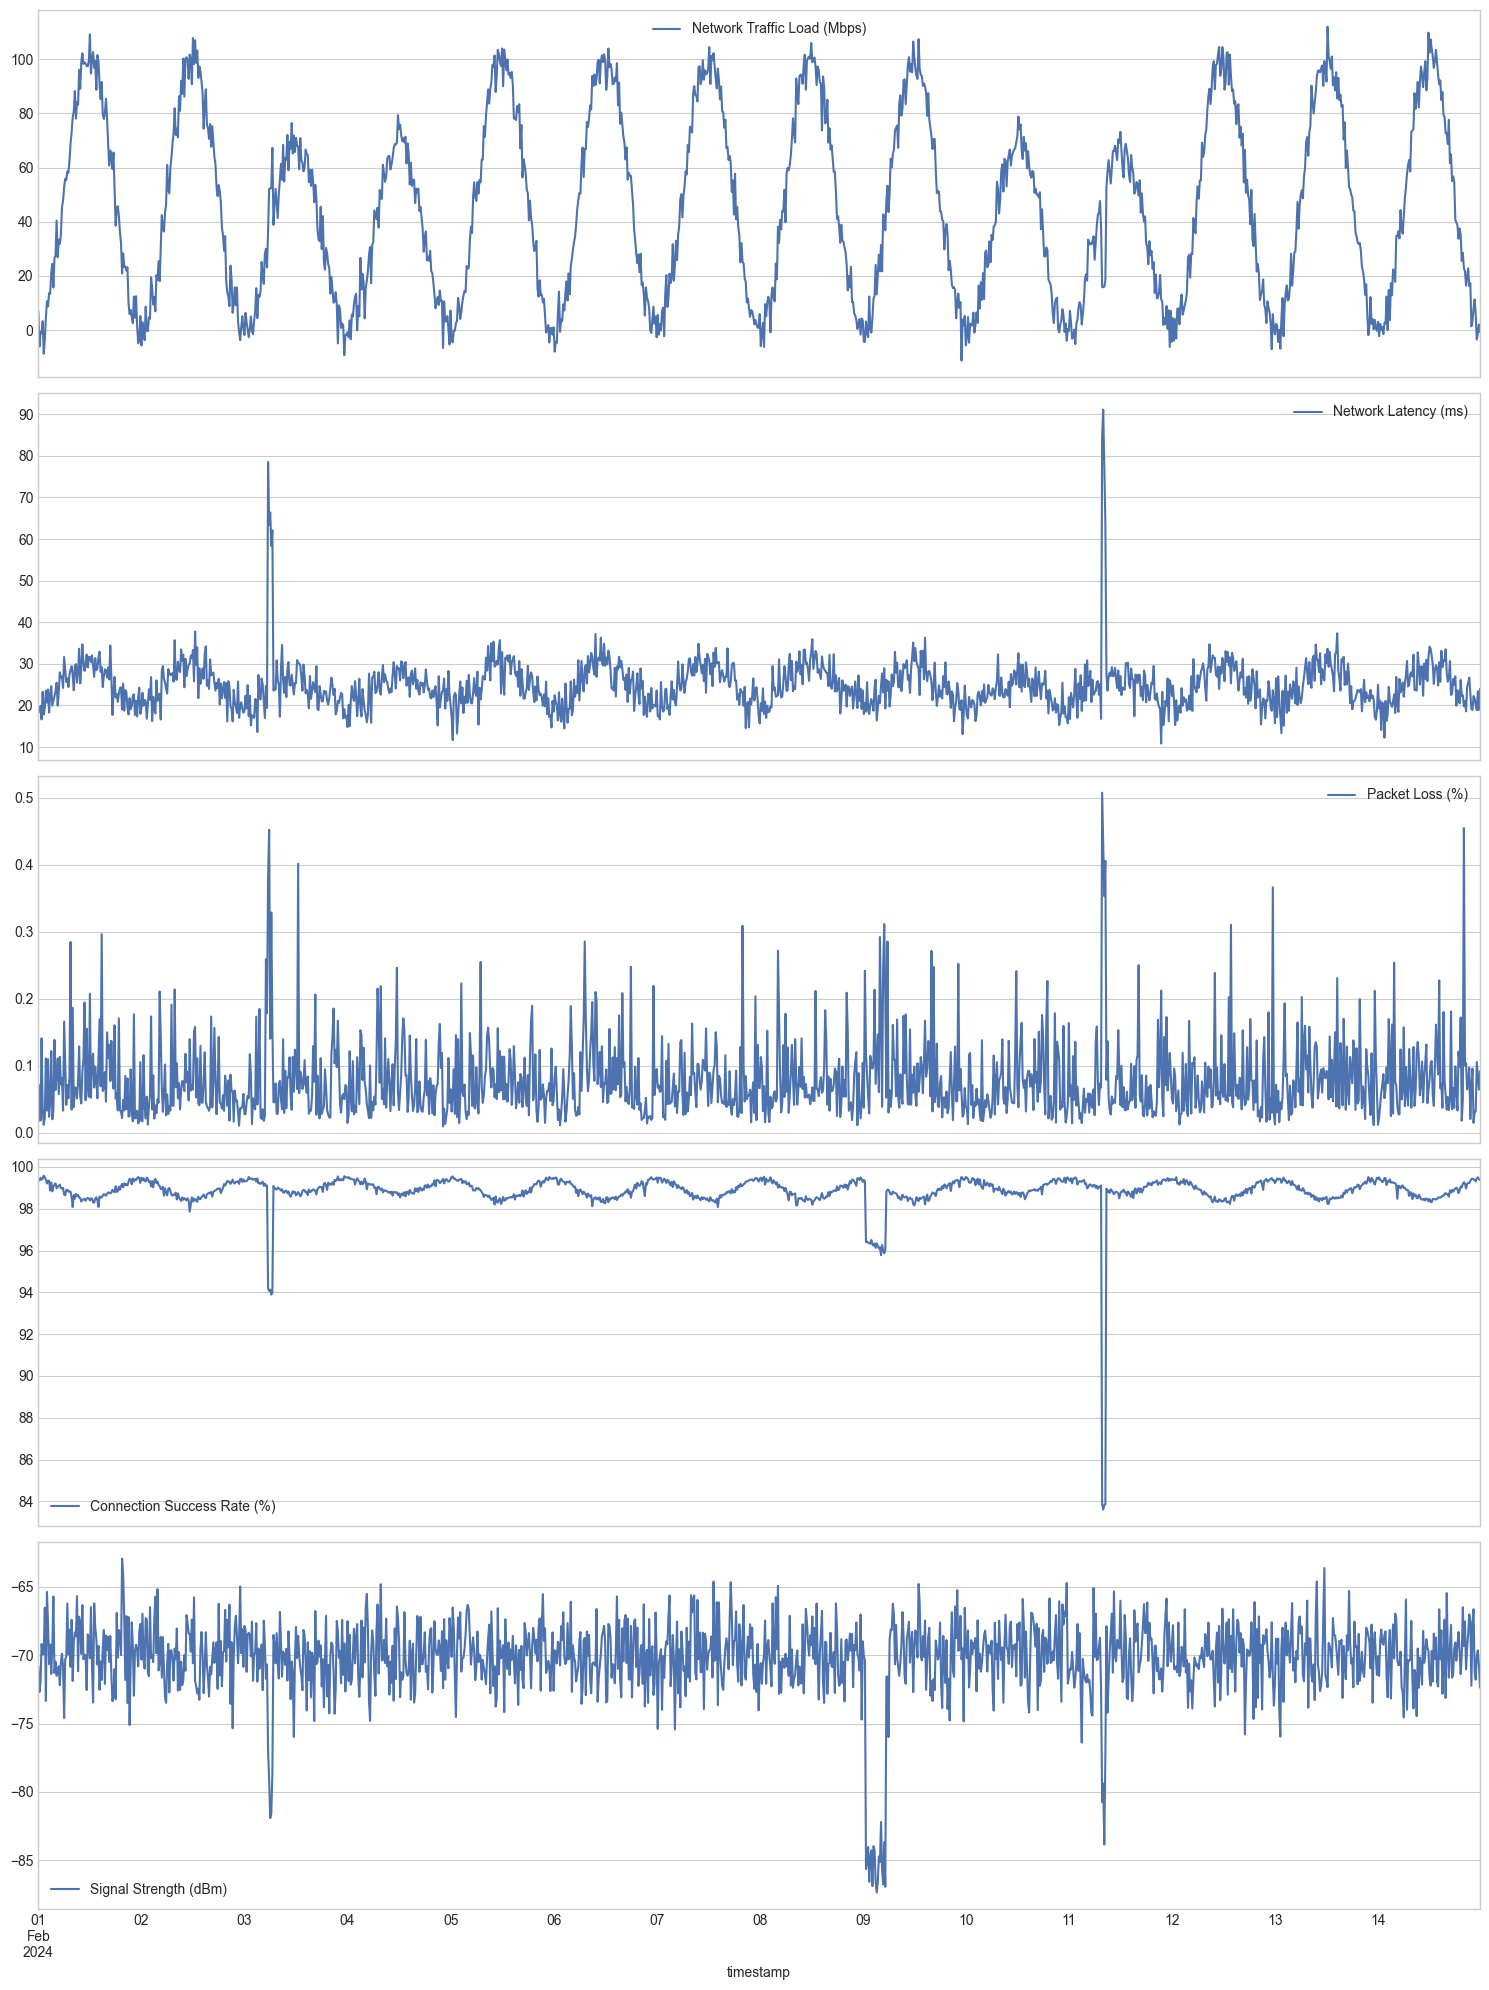

In [75]:
# Plot all KPIs over time
fig, axes = plt.subplots(5, 1, figsize=(15,20), sharex=True)
telecom_kpi_data.plot(x="timestamp", y="traffic_load_mbps", ax=axes[0], label="Network Traffic Load (Mbps)")
telecom_kpi_data.plot(x="timestamp", y="latency_ms", ax=axes[1], label="Network Latency (ms)")
telecom_kpi_data.plot(x="timestamp", y="packet_loss_pct", ax=axes[2], label="Packet Loss (%)")
telecom_kpi_data.plot(x="timestamp", y="conn_success_rate", ax=axes[3], label="Connection Success Rate (%)")
telecom_kpi_data.plot(x="timestamp", y="signal_strength_dbm", ax=axes[4], label="Signal Strength (dBm)")
    
plt.tight_layout()
plt.savefig("telecom_kpi_data.png")
plt.show()

#### Daily patten analysis

In [ ]:
# Group data by hour and calculate mean for each KPI
hourly_patterns = telecom_kpi_data.groupby("hour_of_day").agg({
    "traffic_load_mbps": "mean",
    "latency_ms": "mean",
    "packet_loss_pct": "mean",
    "conn_success_rate": "mean",
    "signal_strength_dbm": "mean"
})

#Plot daily patterns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

hourly_patterns["traffic_load_mbps"].plot(ax=axes[0, 0], title="Average Traffic Load (Mbps) by Hour of Day")
hourly_patterns["latency_ms"].plot(ax=axes[0, 1], title="Average Latency (ms) by Hour of Day")
hourly_patterns["packet_loss_pct"].plot(ax=axes[1, 0], title="Average Packet Loss (%) by Hour of Day")
hourly_patterns["conn_success_rate"].plot(ax=axes[1, 1], title="Average Connection Success Rate (%) by Hour of Day")
hourly_patterns["signal_strength_dbm"].plot(ax=axes[2, 0], title="Average Signal Strength (dBm) by Hour of Day")


axes[2, 1].set_visible(False)

plt.tight_layout()
plt.savefig("hourly_patterns.png")
plt.show()